# Multiple Linear Regression on Merged Dataset

With our abysmal MSE score for Multiple Linear Regression, we wanted to try other methods to see if we could still prove our hypothesis correctly. We merged together both the product_range and transaction datasets and ran Multiple Linear Regression on it.

In [2]:
# import packages and get data
import numpy as np
import pandas as pd
import sklearn #if this doesn't work, run in terminal: $pip3 install -U scikit-learn scipy matplotlib 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date

transactions = pd.read_csv('../data/Transactions.csv')
product_range = pd.read_csv('../data/Product_range.csv')

In [3]:
transactions['Date_and_time_of_unloading'] = pd.to_datetime(transactions['Date_and_time_of_unloading'])
transactions['Date'] = transactions['Date_and_time_of_unloading'].dt.date
transactions = transactions.drop(columns=['Date_and_time_of_unloading'])#,'Discount_amount', 'Percentage_markup', 'Discount_percentage', 'Profit'
transactions = transactions.dropna().reset_index(drop=True)

transactions.head()

,Product_code,Amount,Sale_amount,Discount_amount,Profit,Percentage_markup,Discount_percentage,Date
0,209,2.0,545.73,294.27,75.73,16.11,35.03,2020-01-01
1,213,2.0,1265.05,34.95,653.05,106.71,2.69,2020-01-01
2,217,1.0,630.00,70.00,220.50,53.85,10.00,2020-01-01
3,222,2.0,1104.75,195.25,393.75,55.38,15.02,2020-01-01
4,243,1.0,292.36,157.64,1.36,0.47,35.03,2020-01-01


In [4]:
product_range = product_range.drop(columns=['Base_unit'])#,'Country_of_Origin'
product_range['Name'] = product_range['Name'].str.replace('\d+','', regex=True).str.strip('.')
product_range.columns = ['Product_code', 'Vendor', 'Name', 'Price','Country', 'Size', 'ABV']
product_range['Product_code'] = pd.to_numeric(product_range['Product_code'])
product_range['Price'] = pd.to_numeric(product_range['Price'])
product_range['Size'] = pd.to_numeric(product_range['Size'])
product_range['ABV'] = pd.to_numeric(product_range['ABV'])
product_range = product_range.dropna()
product_range = product_range.reset_index(drop=True)
product_range['Country'] = product_range['Country'].replace(['Denmark', 'United Kingdom', 'Estonia', 'Spain', 'Germany', 'Norway', 'Italy', 'France', '???', 'Ireland', 
                                  'Canada', 'Finland', 'Scotland', 'Japan', 'Latvia', 'Czech', 'Croatia', 'Austria', 'Switzerland', 
                                  'China', 'Brazil', 'Israel'], 'Other')
product_range = pd.get_dummies(product_range, columns = ['Country'])

product_range.head()

,Product_code,Vendor,Name,Price,Size,ABV,Country_Belgium,Country_Netherlands,Country_Other,Country_Russia,Country_Sweden,Country_USA
0,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0,1,0,0,0,0,0
1,1176,3Fonteine,Fonteinen Intense Red Oude Kriek / % /,3300.0,0.750,6.0,1,0,0,0,0,0
2,726,3Fonteine,Fonteinen Oude Geuze / % /,1500.0,0.750,6.0,1,0,0,0,0,0
3,1617,3Fonteine,Fonteinen Oude Geuze / % /,950.0,0.375,5.0,1,0,0,0,0,0
4,4548,3Fonteine,Fonteinen Oude Geuze Assemblage,1100.0,0.375,6.6,1,0,0,0,0,0


In [5]:
# Merge the two datasets
df = product_range.merge(transactions, on= 'Product_code')
print("Merged shape: " + str(df.shape))
df.head()

Merged shape: (29917, 19)


,Product_code,Vendor,Name,Price,Size,ABV,Country_Belgium,Country_Netherlands,Country_Other,Country_Russia,Country_Sweden,Country_USA,Amount,Sale_amount,Discount_amount,Profit,Percentage_markup,Discount_percentage,Date
0,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0,1,0,0,0,0,0,1.0,595.00,255.00,8.00,1.36,30.00,2020-01-15
1,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0,1,0,0,0,0,0,1.0,765.00,85.00,178.00,30.32,10.00,2020-02-10
2,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0,1,0,0,0,0,0,1.0,765.00,85.00,178.00,30.32,10.00,2020-05-06
3,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0,1,0,0,0,0,0,1.0,6.07,843.93,-580.93,-98.97,99.29,2020-05-21
4,1617,3Fonteine,Fonteinen Oude Geuze / % /,950.0,0.375,5.0,1,0,0,0,0,0,1.0,630.00,270.00,106.00,20.23,30.00,2020-01-15


Our merged dataset has almost 30,000 observations - that's definitely a lot of data that our model can learn from.

Our merged dataset now contains the following variables: the product code, vendor, name of drink, price, size, ABV, one-hot-encoded for country of origin, sale amount, discount amount, profit, percentage markup, discount percentage, and date of transaction. That's a lot of data! For now, we'll be selective about what columns we want to analyze, and run Multiple Linear Regression to predict the price (rubles).

We run a heatmap to see any potential correlations; note the high correlations between any price-related column and amount exist because there is generally a relationship between price per item.

/var/folders/1h/p0yg3zrn74952165spggmcxr0000gn/T/ipykernel_11394/2163214035.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),linewidths=0.1, annot=True,cmap='YlGn')


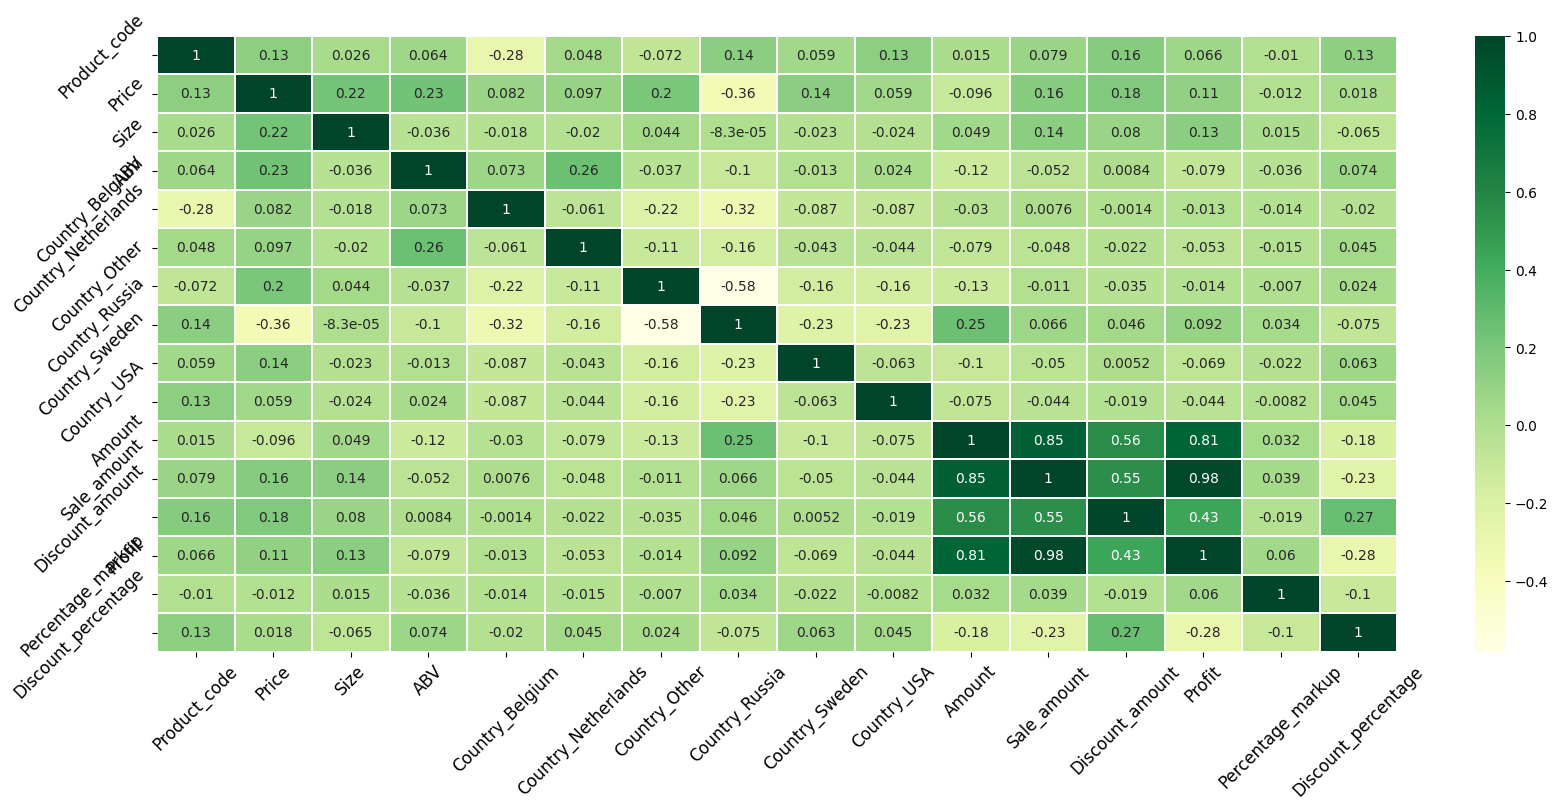

In [8]:
# Plot relationship between all variables of transactions
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(),linewidths=0.1, annot=True,cmap='YlGn')
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12, rotation=45) 
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

X3 = df[['Product_code', 'Size', 'ABV', 'Amount', 'Discount_amount', 'Profit', 'Percentage_markup', 'Discount_percentage', "Sale_amount"]]
Y3 = df['Price']

X3_train, X3_test, y3_train, y3_true = train_test_split(X3, Y3, test_size = 0.8, random_state = 0)

model = LinearRegression()
model.fit(X3_train,y3_train)
y_pred = model.predict(X3_test)
print("The MSE is = " + str(mean_squared_error(y_pred,y3_true)))

The MSE is = 91657.0688735311


Our MSE has improved greatly! From 193,000+ in the product_range dataset, to 160,000+ in the transactions dataset, to 35,000+ in our merged dataset. It's clear that our model has improved greatly with the additional data, but it's still not very accurate yet. 

We plot the predicted values versus the actual values.

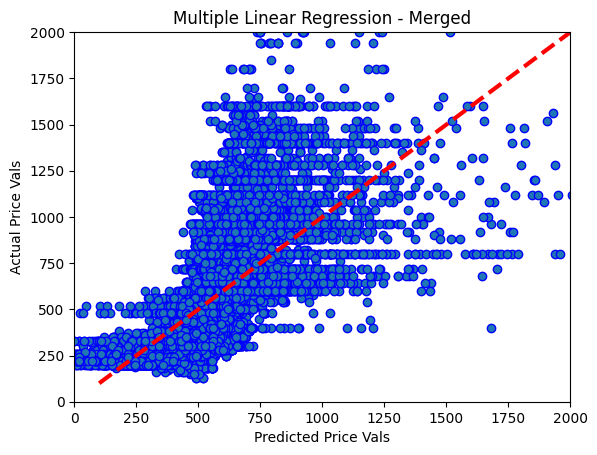

In [10]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y3_true, edgecolors=(0, 0, 1))
ax.plot([y3_true.min(), y3_true.max()], [y3_true.min(), y3_true.max()], 'r--', lw=3)
plt.xlim(0,2000)
plt.ylim(0,2000)
ax.set_xlabel('Predicted Price Vals')
ax.set_ylabel('Actual Price Vals')
plt.title("Multiple Linear Regression - Merged")
plt.show()

Despite our MSE, we can see that most of the predictions and actual values do fall along a distinctive slope. Our model is more accurate this time, but not 100% accurate. 